## Exploratory Data Analysis

In [3]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division




import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go


In [4]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install chart_studio

In [5]:
#Import Data
parse_dates = ['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'shipping_limit_date',
'review_creation_date',
 'review_answer_timestamp',]

OL_Data = pd.read_csv("./OL_Data_Order_Grouped.csv", 
                      parse_dates=parse_dates,
                      date_parser = pd.to_datetime)



OL_Data.dtypes


Unnamed: 0                                int64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
payment_installments                    float64
product_category_name_english            object
seller_id                                object
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
seller_latitude                         float64
seller_longitude                        float64
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                           

<div class="span5 alert alert-info">
<h2>RFM Scoring</h2>
</div>

<h4>Functions</h4>

In [6]:
from sklearn.cluster import KMeans

def PrintKmeansInertiaGraph(dataFrame, column):
    PrintKmeansInertiaGraphWithArray(dataFrame, [column])
    
def PrintKmeansInertiaGraphWithArray(dataFrame, columns):
    sse={}
    columnDF = dataFrame[columns]
    
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(columnDF)
        columnDF.assign(clusters=kmeans.labels_)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
def PerformKMeans(dataFrame, column, numClusters):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[[column]])
    clusterCol = '{0}Cluster'.format(column)
    clusters = kmeans.predict(dataFrame[[column]])
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
    
def PerformKMeansWithArray(dataFrame, columns, numClusters, clusterName):
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataFrame[columns])
    clusterCol = '{0}'.format(clusterName)
    clusters = kmeans.predict(dataFrame[columns])
    print(kmeans.cluster_centers_)
    
    
    if(clusterCol in dataFrame.columns):
        dataFrame.loc[:,clusterCol] = clusters
    else:
        dataFrame[clusterCol] = clusters
        
    
    
#function for ordering cluster numbers
def clustersInOrder(clusterName, targetName, dataFrame, ascending):
    
    #Set New Labels on Clusters, 0-max in order of mean targetName Value
    df_new = dataFrame.groupby(clusterName)[targetName].mean().reset_index()
    df_new = df_new.sort_values(by=targetName,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    #Set New Labels of Clusters to 
    df_final = pd.merge(dataFrame,df_new[[clusterName,'index']], on=clusterName)
    df_final = df_final.drop([clusterName],axis=1)
    df_final = df_final.rename(columns={"index":clusterName})
    
    return df_final

<div class="span5 alert alert-info">
<h3>Buyers</h3>
</div>

<h4>Recency</h4>

count    94467.000000
mean       241.859888
std        152.702590
min          0.000000
25%        118.000000
50%        223.000000
75%        350.000000
max        728.000000
Name: Buyer_Recency, dtype: float64


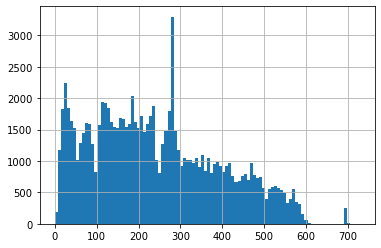

In [7]:
#Recency Score Calc
buyers = pd.DataFrame(OL_Data['customer_unique_id'].unique())
buyers.columns=['CustomerUniqueID']

buyerMaxPurchase = OL_Data.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
buyerMaxPurchase.columns = ['CustomerUniqueID', 'MaxPurchaseDate']

buyerMaxPurchase['Buyer_Recency'] = (buyerMaxPurchase['MaxPurchaseDate'].max() - buyerMaxPurchase['MaxPurchaseDate']).dt.days

buyers = pd.merge(buyers, buyerMaxPurchase[['CustomerUniqueID','Buyer_Recency']])

print(buyers['Buyer_Recency'].describe())
buyers.Buyer_Recency.sort_values().hist(bins=100)
plt.show()


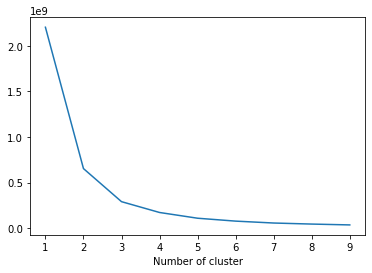

In [8]:
PrintKmeansInertiaGraph(buyers,'Buyer_Recency')

In [9]:
#Generate Recency Clusters, named 'RecencyCluster'
PerformKMeans(buyers,'Buyer_Recency', 4)

#Reset Cluster Names, Lower Recency = More Recent, Higher RecencyCluster
buyers = clustersInOrder('Buyer_RecencyCluster', 'Buyer_Recency', buyers, False)

<h4>Frequency</h4>

count    94467.000000
mean         1.061005
std          0.289504
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Buyer_Frequency, dtype: float64


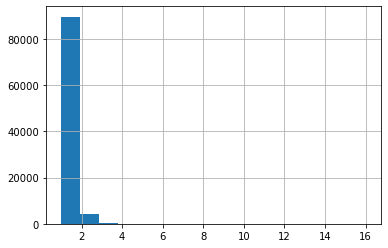

In [10]:
#Frequency
freq = OL_Data.groupby('customer_unique_id').order_id.count().reset_index()
freq.columns = ['CustomerUniqueID','Buyer_Frequency']
freq.head()

buyers = pd.merge(buyers,freq, on='CustomerUniqueID')

print(buyers['Buyer_Frequency'].describe())
buyers.Buyer_Frequency.sort_values().hist(bins=16)
plt.show()

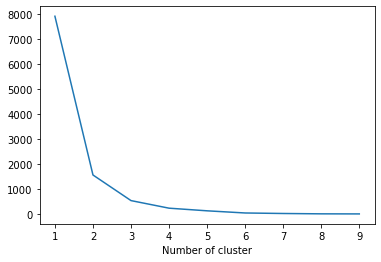

In [11]:
PrintKmeansInertiaGraph(buyers,'Buyer_Frequency')

In [12]:
#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(buyers,'Buyer_Frequency', 4)

#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
buyers = clustersInOrder('Buyer_FrequencyCluster', 'Buyer_Frequency', buyers, True)

<h4>Revenue</h4>

count    94467.000000
mean       182.890726
std        306.673979
min          0.000000
25%         63.230000
50%        108.840000
75%        188.340000
max      13664.080000
Name: Buyer_Revenue, dtype: float64


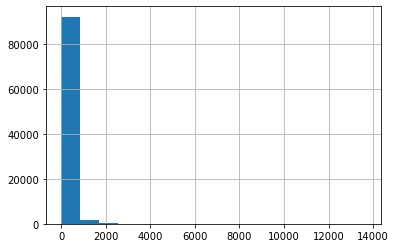

In [13]:
#Revenue
rev = OL_Data.groupby('customer_unique_id').Total_payment.sum().reset_index()
rev.columns = ['CustomerUniqueID','Buyer_Revenue']

buyers = pd.merge(buyers, rev, on='CustomerUniqueID')

print(buyers['Buyer_Revenue'].describe())
buyers.Buyer_Revenue.sort_values().hist(bins=16)
plt.show()

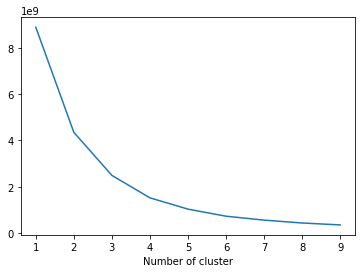

In [14]:
PrintKmeansInertiaGraph(buyers,'Buyer_Revenue')

In [15]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(buyers,'Buyer_Revenue', 5)

#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
buyers = clustersInOrder('Buyer_RevenueCluster', 'Buyer_Revenue', buyers, True)

<h4>Scale RFM and Cluster</h4>

In [16]:
sub = buyers[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue','CustomerUniqueID']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Buyer_Recency']/sub['Buyer_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Buyer_Frequency']/sub['Buyer_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: x['Buyer_Revenue']/sub['Buyer_Revenue'].max(),axis=1))

sub = sub.assign(Buyer_Overall_RFM_Scaled =sub.apply(lambda x: x['scale_recency']+x['scale_frequency']+x['scale_revenue'],axis=1))

sub.columns

Index(['Buyer_Recency', 'Buyer_Frequency', 'Buyer_Revenue', 'CustomerUniqueID',
       'scale_recency', 'scale_frequency', 'scale_revenue',
       'Buyer_Overall_RFM_Scaled'],
      dtype='object')

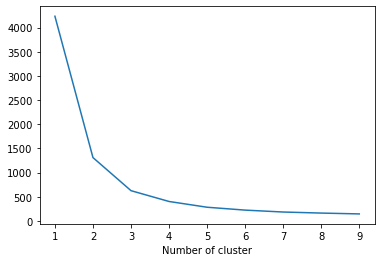

In [17]:
PrintKmeansInertiaGraphWithArray(sub,['scale_recency','scale_frequency','scale_revenue'])

In [18]:
PerformKMeansWithArray(sub, ['scale_recency','scale_frequency','scale_revenue'], 6, 'Buyer_RFM_cluster')

sub.groupby('Buyer_RFM_cluster')[['scale_recency','scale_frequency','scale_revenue']].mean().reset_index()

buyers = buyers.merge(sub[['Buyer_RFM_cluster','CustomerUniqueID','Buyer_Overall_RFM_Scaled']], on='CustomerUniqueID')

[[0.82409379 0.06676381 0.01424707]
 [0.45122002 0.06630317 0.01323215]
 [0.28239193 0.06540878 0.01326156]
 [0.71639315 0.06619117 0.01246571]
 [0.93822768 0.0667041  0.01360141]
 [0.59798352 0.0661544  0.01346865]]


In [19]:
print(buyers.columns)
buyers = clustersInOrder('Buyer_RFM_cluster', 'Buyer_Overall_RFM_Scaled', buyers, True)

Index(['CustomerUniqueID', 'Buyer_Recency', 'Buyer_RecencyCluster',
       'Buyer_Frequency', 'Buyer_FrequencyCluster', 'Buyer_Revenue',
       'Buyer_RevenueCluster', 'Buyer_RFM_cluster',
       'Buyer_Overall_RFM_Scaled'],
      dtype='object')


<h4>Alternative RFM Clustering, sum RFM for overall score</h4>

In [20]:
#calculate overall score and use mean() to see details
buyers['Buyer_OverallRFMScore'] = buyers['Buyer_RecencyCluster'] + buyers['Buyer_FrequencyCluster'] + buyers['Buyer_RevenueCluster']
buyers['Buyer_OverallRFM_Raw'] = buyers['Buyer_Recency'] + buyers['Buyer_Frequency'] + buyers['Buyer_Revenue']

print(buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Recency','Buyer_Frequency','Buyer_Revenue']].mean())

print(buyers.groupby('Buyer_OverallRFMScore')[['Buyer_Revenue']].count())

                       Buyer_Recency  Buyer_Frequency  Buyer_Revenue
Buyer_OverallRFMScore                                               
0                         486.791203         1.000000      96.738402
1                         336.794888         1.011888     123.584019
2                         212.982101         1.029247     145.490389
3                          98.380129         1.046392     170.841535
4                         112.549230         1.278566     469.344052
5                         111.120000         1.663125     875.620869
6                         104.621469         2.180791    1434.112863
7                         102.297468         2.778481    2405.420506
8                          97.207547         4.150943    3225.849434
9                          69.083333         4.166667    4316.088333
                       Buyer_Revenue
Buyer_OverallRFMScore               
0                              13482
1                              21871
2                       

In [21]:
#Assign labels
buyers['Buyer_RFM_Ranking'] = '0-Lowest'
buyers.loc[buyers['Buyer_OverallRFMScore']>=1,'Buyer_RFM_Ranking'] ='1-Low' 
buyers.loc[buyers['Buyer_OverallRFMScore']>=3, 'Buyer_RFM_Ranking'] = '2-Medium'
buyers.loc[buyers['Buyer_OverallRFMScore']>=6, 'Buyer_RFM_Ranking'] = '3-High'
buyers.loc[buyers['Buyer_OverallRFMScore']>=8, 'Buyer_RFM_Ranking'] = '4-Highest'

In [22]:
buyers.head()

,CustomerUniqueID,Buyer_Recency,Buyer_RecencyCluster,Buyer_Frequency,Buyer_FrequencyCluster,Buyer_Revenue,Buyer_RevenueCluster,Buyer_Overall_RFM_Scaled,Buyer_RFM_cluster,Buyer_OverallRFMScore,Buyer_OverallRFM_Raw,Buyer_RFM_Ranking
0,7c396fd4830fd04220f754e42b4e5bff,335,1,2,1,82.82,0,0.670896,2,2,419.82,1-Low
1,0a5df23b922b9998bb7378f1ac03c98a,338,1,2,1,193.83,0,0.674900,2,2,533.83,1-Low
2,95cfb39a7e263160308a934e42cfc4e0,287,1,2,1,122.05,0,0.739701,2,2,411.05,1-Low
3,646d643b4ac1184e383341f8896c3dc8,286,1,2,1,178.04,0,0.745173,2,2,466.04,1-Low
4,6457b2cb5462c1217e8e6d36b0ff39d2,288,1,2,1,171.00,0,0.741910,2,2,461.00,1-Low


<div class="span5 alert alert-info">
<h3>Sellers</h3>
</div>

<h4>Recency</h4>

count    2977.000000
mean      134.126638
std       163.831359
min         0.000000
25%        17.000000
50%        46.000000
75%       210.000000
max       699.000000
Name: Seller_Recency, dtype: float64


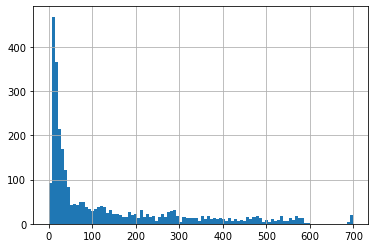

In [23]:
#Recency Score Calc
sellers = pd.DataFrame(OL_Data['seller_id'].unique())
sellers.columns=['SellerID']

sellerMaxSale = OL_Data.groupby('seller_id').order_purchase_timestamp.max().reset_index()
sellerMaxSale.columns = ['SellerID', 'MaxSaleDate']

sellerMaxSale['Seller_Recency'] = (sellerMaxSale['MaxSaleDate'].max() - sellerMaxSale['MaxSaleDate']).dt.days

sellers = pd.merge(sellers, sellerMaxSale[['SellerID','Seller_Recency']])

print(sellers['Seller_Recency'].describe())
sellers.Seller_Recency.sort_values().hist(bins=100)
plt.show()

<h4>Frequency</h4>

count    2977.000000
mean       33.667786
std       108.081772
min         1.000000
25%         2.000000
50%         7.000000
75%        22.000000
max      1865.000000
Name: Seller_Frequency, dtype: float64


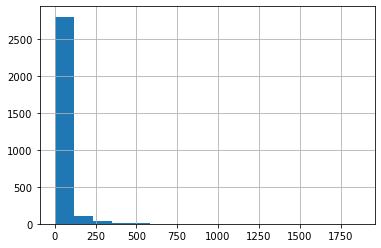

In [24]:
#Frequency
freq = OL_Data.groupby('seller_id').order_id.count().reset_index()
freq.columns = ['SellerID','Seller_Frequency']
freq.head()

sellers = pd.merge(sellers,freq, on='SellerID')

print(sellers['Seller_Frequency'].describe())
sellers.Seller_Frequency.sort_values().hist(bins=16)
plt.show()

<h4>Revenue</h4>

count      2977.000000
mean       5803.513779
std       17929.475314
min          15.220000
25%         315.440000
50%        1164.380000
75%        4533.870000
max      301542.650000
Name: Seller_Revenue, dtype: float64


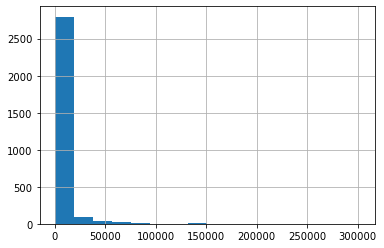

In [25]:
#Revenue
rev = OL_Data.groupby('seller_id').Total_payment.sum().reset_index()
rev.columns = ['SellerID','Seller_Revenue']

sellers = pd.merge(sellers, rev, on='SellerID')

print(sellers['Seller_Revenue'].describe())
sellers.Seller_Revenue.sort_values().hist(bins=16)
plt.show()

Seller_Recency


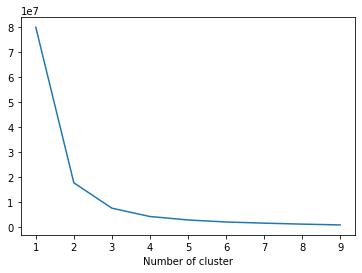


Seller_Frequency


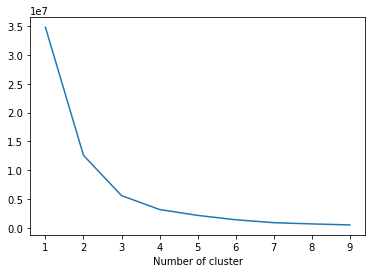


Seller_Revenue


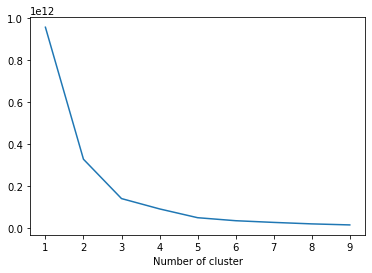

In [26]:
print('Seller_Recency')
PrintKmeansInertiaGraph(sellers,'Seller_Recency')
print('')
print('Seller_Frequency')
PrintKmeansInertiaGraph(sellers,'Seller_Frequency')
print('')
print('Seller_Revenue')
PrintKmeansInertiaGraph(sellers,'Seller_Revenue')

In [27]:
#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Recency', 4)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RecencyCluster', 'Seller_Recency', sellers, False)

print(sellers.groupby('Seller_RecencyCluster').mean())

#Generate Recency Clusters, named 'FrequencyCluster'
PerformKMeans(sellers,'Seller_Frequency', 4)
#Reset Cluster Names, Higher Frequency = More Frequent, Higher Frequency Cluster
sellers = clustersInOrder('Seller_FrequencyCluster', 'Seller_Frequency', sellers, True)

#Generate Revenue Clusters, named 'RevenueCluster'
PerformKMeans(sellers,'Seller_Revenue', 5)
#Reset Cluster Names, Higher Revenue, Higher Revenue Cluster
sellers = clustersInOrder('Seller_RevenueCluster', 'Seller_Revenue', sellers, True)

                       Seller_Recency  Seller_Frequency  Seller_Revenue
Seller_RecencyCluster                                                  
0                          524.697842          3.859712      892.622482
1                          317.158442          9.233766     1627.700727
2                          155.497132         15.931166     3222.886654
3                           27.916248         48.726410     8217.016734


<h4>Scale RFM and Cluster</h4>

In [28]:
sub = sellers[['Seller_Recency','Seller_Frequency','Seller_Revenue','SellerID']]

sub = sub.assign(scale_recency=sub.apply(lambda x: 1 - x['Seller_Recency']/sub['Seller_Recency'].max(),axis=1))
sub = sub.assign(scale_frequency=sub.apply(lambda x: x['Seller_Frequency']/sub['Seller_Frequency'].max(),axis=1))
sub = sub.assign(scale_revenue=sub.apply(lambda x: x['Seller_Revenue']/sub['Seller_Revenue'].max(),axis=1))

sub = sub.assign(Seller_Overall_RFM_Scaled =sub.apply(lambda x: x['scale_recency']+x['scale_frequency']+x['scale_revenue'],axis=1))


sub.head()

,Seller_Recency,Seller_Frequency,Seller_Revenue,SellerID,scale_recency,scale_frequency,scale_revenue,Seller_Overall_RFM_Scaled
0,300,53,3177.71,3504c0cb71d7fa48d967e0e4c94d59d9,0.570815,0.028418,0.010538,0.609772
1,345,6,1125.49,633ecdf879b94b5337cca303328e4a25,0.506438,0.003217,0.003732,0.513387
2,277,10,2062.45,f5f46307a4d15880ca14fab4ad9dfc9b,0.603720,0.005362,0.006840,0.615921
3,339,26,2462.81,c8417879a15366a17c30af34c798c332,0.515021,0.013941,0.008167,0.537130
4,284,40,2870.32,6df688df543f90e9b38f4319e75a9d88,0.593705,0.021448,0.009519,0.624672


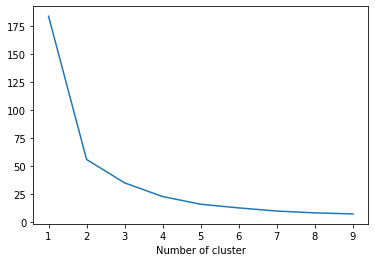

In [29]:
PrintKmeansInertiaGraphWithArray(sub,['scale_recency','scale_frequency','scale_revenue'])

In [30]:
PerformKMeansWithArray(sub, ['scale_recency','scale_frequency','scale_revenue'], 5, 'Seller_RFM_cluster')
sellers = sellers.merge(sub[['Seller_RFM_cluster','SellerID','Seller_Overall_RFM_Scaled']], on='SellerID')

sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
sellers['Seller_OverallRFM_Raw'] = sellers['Seller_Recency'] + sellers['Seller_Frequency'] + sellers['Seller_Revenue']
sellers.columns

[[0.96003609 0.0198437  0.02077166]
 [0.24935931 0.00206955 0.00296019]
 [0.77891012 0.00801741 0.00977837]
 [0.54686836 0.00493104 0.0053743 ]
 [0.98053119 0.52421028 0.54908409]]


Index(['SellerID', 'Seller_Recency', 'Seller_Frequency', 'Seller_Revenue',
       'Seller_RecencyCluster', 'Seller_FrequencyCluster',
       'Seller_RevenueCluster', 'Seller_RFM_cluster',
       'Seller_Overall_RFM_Scaled', 'Seller_OverallRFMScore',
       'Seller_OverallRFM_Raw'],
      dtype='object')

In [31]:
sellers = clustersInOrder('Seller_RFM_cluster', 'Seller_Overall_RFM_Scaled', sellers, True)

<h4>Alternative RFM Clustering, sum RFM for overall score</h4>

In [32]:
#calculate overall score and use mean() to see details
sellers['Seller_OverallRFMScore'] = sellers['Seller_RecencyCluster'] + sellers['Seller_FrequencyCluster'] + sellers['Seller_RevenueCluster']
print(sellers.groupby('Seller_OverallRFMScore')[['Seller_Recency','Seller_Frequency','Seller_Revenue']].mean())

print(sellers.groupby('Seller_OverallRFMScore')[['Seller_Revenue']].count())

                        Seller_Recency  Seller_Frequency  Seller_Revenue
Seller_OverallRFMScore                                                  
0                           525.327273          3.523636      739.880145
1                           317.533512          7.107239     1218.912440
2                           160.169072          8.884536     1668.713052
3                            33.300000         13.675352     2294.258451
4                            34.761111         61.955556    13183.488111
5                            22.877419        128.012903    20094.589097
6                            22.560976        232.658537    46439.367073
7                            14.851852        425.074074    53798.847037
8                            22.625000        638.875000   128986.017500
9                             7.375000       1187.125000   175086.316250
10                           10.600000       1252.600000   254983.110000
                        Seller_Revenue
Seller_Overa

In [33]:
sellers['Seller_RFM_Ranking'] = '0-Lowest'
sellers.loc[sellers['Seller_OverallRFMScore']>=1,'Seller_RFM_Ranking'] ='1-Low' 
sellers.loc[sellers['Seller_OverallRFMScore']>=4, 'Seller_RFM_Ranking'] = '2-Medium'
sellers.loc[sellers['Seller_OverallRFMScore']>=6, 'Seller_RFM_Ranking'] = '3-High'

<h4>Merge in RFM Clusters</h4>

In [34]:
OL_Data = OL_Data.merge(buyers, left_on='customer_unique_id', right_on='CustomerUniqueID')
OL_Data = OL_Data.merge(sellers, left_on='seller_id',right_on='SellerID')
OL_Data.columns

Index(['Unnamed: 0', 'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'payment_installments',
       'product_category_name_english', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'seller_latitude', 'seller_longitude',
       'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_latitude',
       'customer_longitude', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'Total_price',
       'number_of_items', 'Median_payments', 'Total_payment', 'Total_Freight',
       'order_weight_g', 'order_volume_cm3', 'payment_type',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days',
       'Diff_Est_Delivery_vs_Actual', 'CustomerUniqueID', 'Buyer_Recency',
       'Buyer_RecencyCluster', 'Bu

<h3>Add Distance from Buyer to Seller</h3>

In [35]:
#calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
OL_Data['DistanceOfSale'] = OL_Data.apply(lambda x: distance(x.customer_latitude, x.customer_longitude, x.seller_latitude, x.seller_longitude) , axis=1)

In [36]:
OL_Data['DistanceOfSale'].describe()

count    99727.000000
mean       603.487296
std        596.949713
min          0.000000
25%        189.670210
50%        435.533645
75%        801.451936
max       8736.947618
Name: DistanceOfSale, dtype: float64

<h3>Write out data</h3>

In [37]:
OL_Data.to_csv('./OLData_RFM_Metrics.csv')

['1-Low' '0-Lowest' '2-Medium' '3-High' '4-Highest']


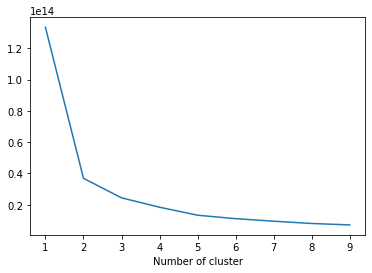

[[ 2.73779721e+00 -2.28475595e+01 -4.73783913e+01 -2.08074303e+01
  -4.59565994e+01  3.73236638e+00  1.10753078e+02  1.12815418e+00
   1.29981175e+02  1.34012408e+02  2.01533512e+01  2.01806822e+03
   1.51023785e+04  1.44087688e+01  1.39319160e+01 -1.02079608e+01
   4.10796514e+02  2.31770867e+04  2.81899464e+00  6.46677127e+02]
 [ 3.05460546e+00 -2.28042777e+01 -4.68758193e+01 -2.06943020e+01
  -4.58179449e+01  3.82118212e+00  1.20775506e+02  1.16471647e+00
   1.39999895e+02  1.46307954e+02  1.98873177e+01  2.52425983e+03
   1.98476619e+04  1.38004800e+01  1.33231323e+01 -1.05412541e+01
   4.37256988e+02  1.55087482e+05  3.93759376e+00  6.25231157e+02]
 [ 3.94099135e+00 -2.17787527e+01 -4.74890771e+01 -2.12504854e+01
  -4.58229396e+01  3.53343824e+00  1.47038969e+02  1.11487018e+00
   1.69327844e+02  1.74308544e+02  2.27505744e+01  4.31317309e+03
   2.99982376e+04  1.74083399e+01  1.69378442e+01 -8.29976397e+00
   4.58369229e+02  2.73720649e+05  4.00000000e+00  5.76895611e+02]]
Index(

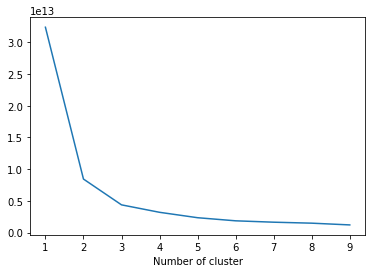

[[ 2.68636151e+00 -2.29437008e+01 -4.71982578e+01 -2.07260637e+01
  -4.61106173e+01  3.93951425e+00  7.61461980e+01  1.09761794e+00
   9.36558711e+01  9.55189234e+01  1.84081784e+01  1.62804787e+03
   1.29056901e+04  1.28089678e+01  1.23904717e+01 -1.41291453e+01
   5.87879269e+02  2.02907194e+04  2.39747781e+00  6.51742449e+02]
 [ 2.98132005e+00 -2.30032991e+01 -4.67431996e+01 -2.09212188e+01
  -4.58808740e+01  4.08468244e+00  8.79923786e+01  1.05479452e+00
   1.05321880e+02  1.06378281e+02  1.77045704e+01  2.34402615e+03
   1.75295280e+04  1.09265255e+01  1.05354919e+01 -1.46612702e+01
   5.92436812e+02  1.44627271e+05  3.88792030e+00  6.12188112e+02]
 [ 3.54545455e+00 -2.23901676e+01 -4.79294300e+01 -2.12404974e+01
  -4.59961515e+01  3.70846395e+00  1.08170909e+02  1.04075235e+00
   1.25847790e+02  1.28087743e+02  2.04976803e+01  3.88599687e+03
   3.15304044e+04  1.53667712e+01  1.49435737e+01 -1.09090909e+01
   6.02536019e+02  2.81053546e+05  4.00000000e+00  5.96356973e+02]]
Index(

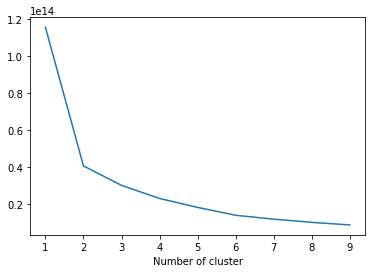

[[ 3.22982904e+00 -2.27066680e+01 -4.72233517e+01 -2.10395430e+01
  -4.60899390e+01  3.81820995e+00  1.90432064e+02  1.25783244e+00
   2.14103849e+02  2.35356965e+02  2.64614829e+01  2.91452417e+03
   1.97225808e+04  1.06955984e+01  1.02443722e+01 -1.23551481e+01
   4.04766422e+02  2.12836114e+04  2.94909879e+00  6.15844519e+02]
 [ 3.76925770e+00 -2.22659890e+01 -4.67952130e+01 -2.02602180e+01
  -4.56116690e+01  3.75945378e+00  2.11159975e+02  1.32282913e+00
   2.30530937e+02  2.67395564e+02  2.69730217e+01  4.07901891e+03
   2.76290980e+04  1.19894958e+01  1.15297619e+01 -1.17692577e+01
   4.68889821e+02  2.00180249e+05  4.00000000e+00  6.31743485e+02]]
Index(['payment_installments', 'seller_latitude', 'seller_longitude',
       'customer_latitude', 'customer_longitude', 'review_score',
       'Total_price', 'number_of_items', 'Median_payments', 'Total_payment',
       'Total_Freight', 'order_weight_g', 'order_volume_cm3',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days

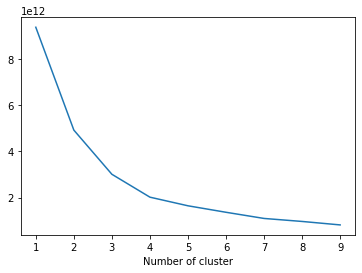

[[ 4.79479769e+00 -2.27842843e+01 -4.73476371e+01 -2.11230673e+01
  -4.60645569e+01  3.10549133e+00  4.19915130e+02  2.13294798e+00
   4.36764191e+02  7.06399855e+02  3.97372399e+01  3.39756069e+03
   2.19277182e+04  9.62427746e+00  9.19364162e+00 -1.65809249e+01
   1.67272610e+03  2.59553863e+04  2.92630058e+00  6.48916550e+02]
 [ 4.52287582e+00 -2.22969229e+01 -4.72560857e+01 -2.06166074e+01
  -4.58448273e+01  3.02614379e+00  3.12751111e+02  2.01960784e+00
   3.43639641e+02  6.45259542e+02  4.51313725e+01  5.83035294e+03
   4.02996797e+04  1.01503268e+01  9.60130719e+00 -1.46274510e+01
   1.63478026e+03  2.05942659e+05  4.00000000e+00  6.24770196e+02]
 [ 7.42857143e+00 -2.34893508e+01 -4.64218036e+01 -1.75879729e+01
  -4.24760487e+01  2.14285714e+00  8.70135714e+02  7.28571429e+00
   1.46076143e+03  2.32324571e+03  1.24997143e+02  8.16395714e+04
   5.37913714e+05  2.28571429e+01  2.18571429e+01 -1.45714286e+01
   3.80618000e+03  1.85472527e+05  3.71428571e+00  8.66476673e+02]
 [ 5.68

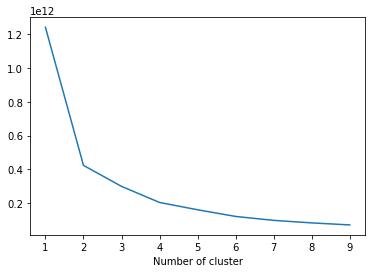

[[ 4.69387755e+00 -2.28591054e+01 -4.79242929e+01 -2.18589496e+01
  -4.64346699e+01  2.60204082e+00  3.99936735e+02  3.15306122e+00
   3.95465255e+02  8.61456837e+02  4.43930612e+01  4.53219388e+03
   3.05648673e+04  9.38775510e+00  8.97959184e+00 -1.93163265e+01
   3.24855010e+03  2.07332366e+04  2.91836735e+00  6.43693227e+02]
 [ 3.57142857e+00 -2.25046525e+01 -4.76403886e+01 -1.71396453e+01
  -4.61566999e+01  3.85714286e+00  5.00751429e+02  3.71428571e+00
   6.45124286e+02  1.60179857e+03  9.39357143e+01  2.38761429e+04
   1.71628571e+05  7.14285714e+00  5.85714286e+00 -1.67142857e+01
   4.65855286e+03  2.27713119e+05  4.00000000e+00  7.43827239e+02]
 [ 6.55555556e+00 -2.25702505e+01 -4.77265436e+01 -2.07306996e+01
  -4.40105188e+01  3.00000000e+00  2.69576667e+02  2.61111111e+00
   3.39098333e+02  6.99015000e+02  4.57855556e+01  3.81522222e+03
   3.62711667e+04  7.77777778e+00  7.22222222e+00 -1.56666667e+01
   2.20390556e+03  2.13827409e+05  4.00000000e+00  8.08039229e+02]
 [ 5.46

In [38]:
clusters={"1-Low":3,"0-Lowest":3,"2-Medium":2,"3-High":4,"4-Highest":4}

print(OL_Data['Buyer_RFM_Ranking'].unique())

for t in OL_Data['Buyer_RFM_Ranking'].unique():
    subset = OL_Data[OL_Data['Buyer_RFM_Ranking']==t]
    
    numcols = ['payment_installments',
            'seller_latitude', 
            'seller_longitude',
            'customer_latitude',
            'customer_longitude', 
            'review_score',
            'Total_price',
            'number_of_items', 
            'Median_payments', 
            'Total_payment', 
            'Total_Freight',
            'order_weight_g', 
            'order_volume_cm3', 
            'Purchase_To_Delivery_Days', 
            'Approved_To_Delivery_Days',
            'Diff_Est_Delivery_vs_Actual',
            'Buyer_OverallRFM_Raw',
            'Seller_OverallRFM_Raw', 
            'Seller_RFM_cluster',
            'DistanceOfSale']
    
    test = numcols+['order_id']
    subset = subset[test].dropna()
    
    
    PrintKmeansInertiaGraphWithArray(subset,numcols)
    PerformKMeansWithArray(subset, numcols, clusters[t], "{0}-SubClusers".format(t))
    print(subset.columns)
    OL_Data.merge(subset[['order_id',"{0}-SubClusers".format(t)]], on='order_id')
    

In [39]:
OL_Data.columns

Index(['Unnamed: 0', 'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date', 'payment_installments',
       'product_category_name_english', 'seller_id', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'seller_latitude', 'seller_longitude',
       'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_latitude',
       'customer_longitude', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'Total_price',
       'number_of_items', 'Median_payments', 'Total_payment', 'Total_Freight',
       'order_weight_g', 'order_volume_cm3', 'payment_type',
       'Purchase_To_Delivery_Days', 'Approved_To_Delivery_Days',
       'Diff_Est_Delivery_vs_Actual', 'CustomerUniqueID', 'Buyer_Recency',
       'Buyer_RecencyCluster', 'Bu

In [40]:

AllOrderLines = []
for index, row in OL_Data.iterrows():
    originRow = {}
    destRow = {}
    
    originRow['Origin-Destination'] = 'Origin'
    destRow['Origin-Destination'] = 'Destination'

    idName = "{0}-{1}".format(row['customer_id'],index)
    originRow['PathId'] = idName
    destRow['PathId'] = idName

    originRow['Latitude'] = row['seller_latitude']
    originRow['Longitude'] = row['seller_longitude']
    destRow['Latitude'] = row['customer_latitude']
    destRow['Longitude'] =  row['customer_longitude']
    
    originRow['Buyer_RFM_Ranking'] = row['Buyer_RFM_Ranking']
    destRow['Buyer_RFM_Ranking'] = row['Buyer_RFM_Ranking']    
    originRow['Seller_RFM_Ranking'] = row['Seller_RFM_Ranking']
    destRow['Seller_RFM_Ranking'] = row['Seller_RFM_Ranking']
    
    AllOrderLines.append(originRow)
    AllOrderLines.append(destRow)
    
mapDf = pd.DataFrame(AllOrderLines)
mapDf.to_csv('./OrderMapData.csv')

In [100]:
OL_DataSub = OL_Data[(OL_Data['Seller_OverallRFMScore']>=1) & (OL_Data['Buyer_OverallRFMScore']>=1)]

In [101]:
BuyerSellerMatrix = pd.pivot_table(OL_DataSub, columns=['seller_id'], index=['customer_id'],values='order_id', fill_value=0, aggfunc=len).reset_index()
BuyerCategoryMatrix = pd.pivot_table(OL_DataSub, columns=['product_category_name_english'], index=['customer_id'],values='order_id', fill_value=0, aggfunc=len).reset_index()
SellerCategoryMatrix = pd.pivot_table(OL_DataSub, columns=['product_category_name_english'], index=['seller_id'],values='order_id', fill_value=0, aggfunc=len).reset_index()

In [127]:
import warnings
import os
from os.path import exists
warnings.filterwarnings('ignore')

def GenerateSimularityScores(dataFrame, indexName, fileName):
    if(exists(fileName)):
        os.remove(fileName)
    
    values = dataFrame.loc[:, dataFrame.columns!=indexName].to_numpy()
    lfunc = lambda e: e%2;
    values = lfunc(values)
    
    with open("./"+fileName, 'w') as f:
        indexValues = np.transpose(dataFrame[[indexName]].to_numpy())[0]
        header = "{0},".format(indexName) + ",".join(indexValues) + "\n"
        f.write(header)
        
        for x in range(len(indexValues)):

            if(x%(len(indexValues)//100) ==0):
                print("{0}% ".format(x/len(indexValues)*100))

            index = indexValues[x]
            sellerCol = np.transpose(dataFrame.loc[dataFrame[indexName]==index, dataFrame.columns!=indexName].to_numpy())
            result = np.transpose(np.matmul(values,sellerCol))
            print(values.shape)
            print(sellerCol.shape)
            print(np.matmul(values,sellerCol).shape)
            print(result.shape)
            converted_list = [str(element) for element in result]
            print(converted_list)
            
            text = "{0},".format(index) + ",".join(converted_list) + "\n"
            f.write(text)
            
        f.close()
        
    return pd.read_csv("./"+fileName)

In [128]:
sellerCategorySimularity = GenerateSimularityScores(SellerCategoryMatrix,'seller_id', 'SellerCategoryMatrix.csv')



0.0% 
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[3 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[ 0  0  0 ... 52  0  0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[ 0  0  0 ...  0  0 13]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634,

(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[ 0  0  0 ...  0  0 53]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 1]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
5.922551252847381% 
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[ 0  0  0 ...  0  

(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 1]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
11.845102505694761% 
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[ 0  0  0 ...  5  0 11]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[ 0  0  0 ... 28  0  6]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[ 0  0  0 ...  0  0 12]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 2 0 1]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(263

(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 1]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
17.76765375854214% 
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 1 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 2 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 1]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(263

(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 3]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 6 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 0 0 0]']
(2634, 71)
(71, 1)
(2634, 1)
(1, 2634)
['[0 0 0 ... 5 0 0]']
(2634, 71)
(71, 1)
(2634

KeyboardInterrupt: 

In [118]:
sellerCategorySimularity.head()

,seller_id,0015a82c2db000af6aaaf3ae2ecb0532,001cca7ae9ae17fb1caed9dfb1094831,002100f778ceb8431b7a1020ff7ab48f,004c9cd9d87a3c30c522c48c4fc07416,00720abe85ba0859807595bbf045a33b,00d8b143d12632bad99c0ad66ad52825,00ee68308b45bc5e2660cd833c3f81cc,00fc707aaaad2d31347cf883cd2dfe10,010543a62bd80aa422851e79a3bc7540,...,ff1fb4c404b2efe68b03350a8dc24122,ff4e2d38692ce827b1a4f4b8196e680d,ff69aa92bb6b1bf9b8b7a51c2ed9cf8b,ff82e8873fba613f2261a9acc896fd84,ffa6adafb71b807dc13159e26431354c,ffad1e7127fb622cb64a900751590acd,ffc470761de7d0232558ba5e786e57b7,ffdd9f82b9a447f6f8d4b91554cc7dd3,ffeee66ac5d5a62fe688b9d26f83f534,fffd5413c0700ac820c7069d66d98c89
0,0015a82c2db000af6aaaf3ae2ecb0532,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,001cca7ae9ae17fb1caed9dfb1094831,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,002100f778ceb8431b7a1020ff7ab48f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,52,52,0,0
3,004c9cd9d87a3c30c522c48c4fc07416,0,0,0,107,0,0,107,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00720abe85ba0859807595bbf045a33b,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13


In [103]:
buyerCategorySimularity = GenerateSimularityScores(BuyerCategoryMatrix,'customer_id')


0.0% 
0.99939649969825% 
1.9987929993965% 
2.9981894990947495% 
3.997585998793% 
4.996982498491249% 
5.996378998189499% 
6.995775497887749% 
7.995171997586% 
8.994568497284249% 
9.993964996982498% 


KeyboardInterrupt: 

In [ ]:
sellerBuyerSimularity = GenerateSimularityScores(BuyerSellerMatrix, 'customer_id')

In [ ]:
sellerCategorySimularity.to_csv('./sellerCategorySimularity.csv')
buyerCategorySimularity.to_csv('./buyerCategorySimularity.csv')
sellerBuyerSimularity.to_csv('./sellerBuyerSimularity.csv')

In [ ]:
sns.set(rc = {'figure.figsize':(500,500)})
sns.heatmap(sellerCategorySimularity, annot=False)